In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import matplotlib as mpl
import datetime as dt

### Salient Features of this model
- Algorithms used for Network Classification: Majority Voting and Label Averaging with different sets of iterations
- Majority Voting involves predicting the unknown labels of unlabeled nodes/stations by considering the labels of the neighboring nodes/stations after a chosen number of iterations (100, 200 & 500 in this case)
- Label Averaging involves averaging the scores of the neighboring nodes from the previous iteration
- Accuracy and F1 scores were used as metrics to compare the performances of these algorithms

Some of the data cleaning steps used here are derived from the Master File under the EDA section of the codebook.

In [4]:
#Import data file
df = pd.read_csv('Input File/201912-citibike-tripdata.csv')

In [5]:
#Check data frame
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,602,2019-12-01 00:00:05.5640,2019-12-01 00:10:07.8180,3382,Carroll St & Smith St,40.680611,-73.994758,3304,6 Ave & 9 St,40.668127,-73.983776,41932,Subscriber,1970,1
1,1206,2019-12-01 00:00:10.9630,2019-12-01 00:20:17.8820,362,Broadway & W 37 St,40.751726,-73.987535,500,Broadway & W 51 St,40.762288,-73.983362,18869,Customer,1999,1
2,723,2019-12-01 00:00:11.8180,2019-12-01 00:12:14.8310,146,Hudson St & Reade St,40.716250,-74.009106,238,Bank St & Washington St,40.736197,-74.008592,15334,Subscriber,1997,1
3,404,2019-12-01 00:00:12.2200,2019-12-01 00:06:56.8860,3834,Irving Ave & Halsey St,40.694670,-73.906630,3827,Halsey St & Broadway,40.685650,-73.915640,41692,Customer,1995,1
4,1059,2019-12-01 00:00:14.7230,2019-12-01 00:17:54.1860,500,Broadway & W 51 St,40.762288,-73.983362,3323,W 106 St & Central Park West,40.798186,-73.960591,40156,Subscriber,1961,1


In [6]:
#Check percentage of missing data in the dataset
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data(df)

,Total,Percent
gender,0,0.0
birth year,0,0.0
usertype,0,0.0
bikeid,0,0.0
end station longitude,0,0.0
end station latitude,0,0.0
end station name,0,0.0
end station id,0,0.0
start station longitude,0,0.0
start station latitude,0,0.0


In [7]:
#Drop missing values 
df.dropna(inplace = True)

In [8]:
#Convert variables to the correct data format types
df['start station name'] = df['start station name'].astype('category')
df['end station name'] = df['end station name'].astype('category')
df['usertype'] = df['usertype'].astype('category')
df['gender'] = df['gender'].astype('category')
round(df.describe())


,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year
count,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0,955210.0
mean,831.0,1667.0,41.0,-74.0,1647.0,41.0,-74.0,32916.0,1979.0
std,10786.0,1493.0,0.0,0.0,1491.0,0.0,0.0,7997.0,13.0
min,61.0,72.0,41.0,-74.0,72.0,41.0,-74.0,14529.0,1885.0
25%,320.0,380.0,41.0,-74.0,379.0,41.0,-74.0,28716.0,1969.0
50%,522.0,509.0,41.0,-74.0,507.0,41.0,-74.0,34101.0,1982.0
75%,876.0,3311.0,41.0,-74.0,3307.0,41.0,-74.0,39839.0,1990.0
max,3304262.0,3911.0,41.0,-74.0,3911.0,41.0,-74.0,42046.0,2003.0


In [9]:
#Rename columns in data frame
df.columns = [j.replace(' ', '_') for j in df.columns]

In [10]:
#Exclude bike trips that record trip duration as <90s and which start station & end station is the same. 
#This takes care of faulty bikes that users may have picked up, then realised that they were faulty and returned them back to the same station, typically within 90s.
df = df.drop(df.index[(df['tripduration'] < 90) & 
                          (df['start_station_latitude'] == df['start_station_latitude'])])

In [11]:
trips_df1 = df.groupby('start_station_name').size().reset_index(name = 'number_of_trips')
trips_df1.sort_values('number_of_trips', ascending = False, inplace = True)
trips_df1.columns=['station_name','number_of_trips']
# trips_df1

In [12]:
trips_df = trips_df1
# trips_df

In [13]:
trips_df.describe()

,number_of_trips
count,881.000000
mean,1076.526674
std,1132.874232
min,4.000000
25%,243.000000
50%,655.000000
75%,1599.000000
max,7541.000000


Text(0, 0.5, 'Count')

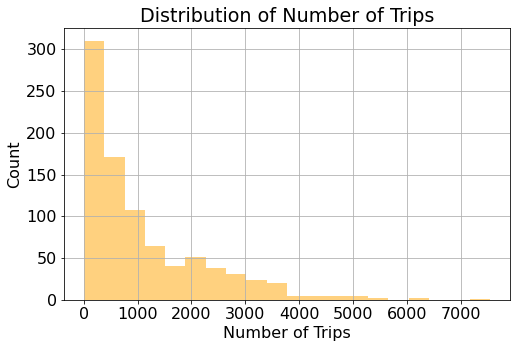

In [14]:
# Plot the distribution of number of trips 
plt.rcParams.update({'font.size': 16})
trips_df['number_of_trips'].hist(figsize = (8,5), bins = 20, alpha = 0.5, color = 'orange')
plt.title('Distribution of Number of Trips')
plt.xlabel('Number of Trips')
plt.ylabel('Count')

In [15]:
#Define frequency of trips by "high", "low"
trips_df['Frequency of Trips'] = np.where(trips_df['number_of_trips'] > 1599, 1, 0)
# trips_df

In [16]:
trips_df = trips_df.drop(['number_of_trips'], axis = 1)
# trips_df

In [17]:
trips_df['Frequency of Trips'].value_counts()

0    662
1    219
Name: Frequency of Trips, dtype: int64

In [18]:
trips_df.to_csv('Misc_Files/Number_of_trips_Dec_Month.txt', index = False, header = False)

In [19]:
node_df = df[['start_station_name', 'end_station_name']]

In [20]:
node_df.to_csv('Misc_Files/Nodes.txt', index = False, header = False)

#### Majority Voting Method

Most of the codes in this section have been taken from the class notes and have been transformed for our project data and use-case. The majority voting method here has been tried for different number of iterations to observe if there is any noticeable change in the model accuracy and results.

In [21]:
import networkx as nx

# read graph
g = nx.Graph()
with open('Misc_Files/Nodes.txt', 'r') as fin:
        next(fin)
        for line in fin:
            #print(line)
            parts = line.strip().split(',')
            g.add_edge(parts[0], parts[1])
            
# declare node labels 
labels = {}

with open('Misc_Files/Number_of_trips_Dec_Month.txt', 'r') as fin:
    for line in fin:
        cols = line.strip().split(',')        
        node = cols[0]
        #l.append(cols[1])
        if cols[1] == '1':
            labels[node] = 1
        else:
            labels[node] = 0

In [22]:
g.remove_node('Sip Ave')

In [23]:
import numpy as np

train_labels = {}

np.random.seed(10)
# setting the seed ensures that every time we run the code, the same 200 nodes are sampled
# if you change the seed value, a different 200 nodes will be sampled

sampled = np.random.choice(list(labels.keys()), size = 100, replace = False)


# add sampled nodes and their corresponding labels to train_labels
for node in sampled:
    train_labels[node] = labels[node] 

In [24]:
len(train_labels)

100

In [25]:
def majority_voting(g, train_labels, iteration=100):
    '''
    g: the graph
    train_labels: a dictionary containing (node id, label) for labeled training nodes.
    iteration: number of iterations to run
    return the labels of the unlabeled test nodes as a dictionary
    '''
    
    # initial state 
    # only nodes in the training data gets a initial label
    f = {}
    for node in g.nodes:
        if node in train_labels:
            f[node] = train_labels[node]
        else:
            f[node] = None

    
    # run for multiple iterations
    for iter in range(iteration):
        # find majority class for each unlabeled node
        f_new = {}
        for node in g.nodes:
            if node in train_labels:
                # do not change the label for labeled training nodes
                f_new[node] = train_labels[node]  
            else:
                # majority voting for unlabeled test nodes
                # count number of neighbors with different labels
                votes_1 = 0
                votes_0 = 0
                for nb in g[node]:
                    if f[nb] == 1:
                        votes_1 += 1
                    elif f[nb] == 0:
                        votes_0 += 1
                if votes_1 == 0 and votes_0 == 0:
                    f_new[node] = None
                elif votes_1 >= votes_0:
                    f_new[node] = 1
                else:
                    f_new[node] = 0
        f = f_new
    
    # only return the predicted labels of unlabeled test nodes
    # i.e. those nodes not in training data
    pred = {}
    for node in f:
        if node not in train_labels:
            if f[node] == 1:
                pred[node] = 1
            else:
                pred[node] = 0
            
    return pred

In [26]:
pred = majority_voting(g, train_labels)

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# prepare list of predictions and groundtruth labels
# the two list must contain the test nodes in the same order
pred_list = []
groundtruth_list = []
for node in g.nodes:
    if node not in train_labels:
        pred_list.append(pred[node])
        #print(node)
        groundtruth_list.append(labels[node])
    
# compute accuracy and f1-score
print('accuracy =', accuracy_score(groundtruth_list, pred_list))
print('f1 =', f1_score(groundtruth_list, pred_list))

accuracy = 0.7592829705505761
f1 = 0.6690140845070423


In [28]:
def majority_voting(g, train_labels, iteration=200):
    '''
    g: the graph
    train_labels: a dictionary containing (node id, label) for labeled training nodes.
    iteration: number of iterations to run
    return the labels of the unlabeled test nodes as a dictionary
    '''
    
    # initial state 
    # only nodes in the training data gets a initial label
    f = {}
    for node in g.nodes:
        if node in train_labels:
            f[node] = train_labels[node]
        else:
            f[node] = None

    
    # run for multiple iterations
    for iter in range(iteration):
        # find majority class for each unlabeled node
        f_new = {}
        for node in g.nodes:
            if node in train_labels:
                # do not change the label for labeled training nodes
                f_new[node] = train_labels[node]  
            else:
                # majority voting for unlabeled test nodes
                # count number of neighbors with different labels
                votes_1 = 0
                votes_0 = 0
                for nb in g[node]:
                    if f[nb] == 1:
                        votes_1 += 1
                    elif f[nb] == 0:
                        votes_0 += 1
                if votes_1 == 0 and votes_0 == 0:
                    f_new[node] = None
                elif votes_1 >= votes_0:
                    f_new[node] = 1
                else:
                    f_new[node] = 0
        f = f_new
    
    # only return the predicted labels of unlabeled test nodes
    # i.e. those nodes not in training data
    pred = {}
    for node in f:
        if node not in train_labels:
            if f[node] == 1:
                pred[node] = 1
            else:
                pred[node] = 0
            
    return pred

In [29]:
pred = majority_voting(g, train_labels)

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# prepare list of predictions and groundtruth labels
# the two list must contain the test nodes in the same order
pred_list = []
groundtruth_list = []
for node in g.nodes:
    if node not in train_labels:
        pred_list.append(pred[node])
        groundtruth_list.append(labels[node])

# compute accuracy and f1-score
print('accuracy =', accuracy_score(groundtruth_list, pred_list))
print('f1 =', f1_score(groundtruth_list, pred_list))

accuracy = 0.7592829705505761
f1 = 0.6690140845070423


In [31]:
def majority_voting(g, train_labels, iteration=500):
    '''
    g: the graph
    train_labels: a dictionary containing (node id, label) for labeled training nodes.
    iteration: number of iterations to run
    return the labels of the unlabeled test nodes as a dictionary
    '''
    
    # initial state 
    # only nodes in the training data gets a initial label
    f = {}
    for node in g.nodes:
        if node in train_labels:
            f[node] = train_labels[node]
        else:
            f[node] = None

    
    # run for multiple iterations
    for iter in range(iteration):
        # find majority class for each unlabeled node
        f_new = {}
        for node in g.nodes:
            if node in train_labels:
                # do not change the label for labeled training nodes
                f_new[node] = train_labels[node]  
            else:
                # majority voting for unlabeled test nodes
                # count number of neighbors with different labels
                votes_1 = 0
                votes_0 = 0
                for nb in g[node]:
                    if f[nb] == 1:
                        votes_1 += 1
                    elif f[nb] == 0:
                        votes_0 += 1
                if votes_1 == 0 and votes_0 == 0:
                    f_new[node] = None
                elif votes_1 >= votes_0:
                    f_new[node] = 1
                else:
                    f_new[node] = 0
        f = f_new
    
    # only return the predicted labels of unlabeled test nodes
    # i.e. those nodes not in training data
    pred = {}
    for node in f:
        if node not in train_labels:
            if f[node] == 1:
                pred[node] = 1
            else:
                pred[node] = 0
            
    return pred

In [32]:
pred = majority_voting(g, train_labels)

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# prepare list of predictions and groundtruth labels
# the two list must contain the test nodes in the same order
pred_list = []
groundtruth_list = []
for node in g.nodes:
    if node not in train_labels:
        pred_list.append(pred[node])
        groundtruth_list.append(labels[node])

# compute accuracy and f1-score
print('accuracy =', accuracy_score(groundtruth_list, pred_list))
print('f1 =', f1_score(groundtruth_list, pred_list))

accuracy = 0.7592829705505761
f1 = 0.6690140845070423


#### Label averaging algorithm

The code for this algorithm has also been taken from the class notes and has been reformed for our project pruposes. 

In [34]:
import networkx as nx
import numpy as np

# read graph
g = nx.Graph()
with open('Misc_Files/Nodes.txt', 'r') as fin:
        next(fin)
        for line in fin:
            #print(line)
            parts = line.strip().split(',')
            g.add_edge(parts[0], parts[1])
            
# declare node labels 
labels = {}

with open('Misc_Files/Number_of_trips_Dec_Month.txt', 'r') as fin:
    for line in fin:
        cols = line.strip().split(',')        
        node = cols[0]
        if cols[1] == '1':
            labels[node] = 1
        else:
            labels[node] = 0

# splitting training and test data
train_labels = {}
np.random.seed(120)
# setting the seed ensures that every time we run the code, the same 100 nodes will be sampled
# if you change the seed value, a different 100 nodes will be sampled

sampled = np.random.choice(list(labels.keys()), size = 100, replace = False)

# add sampled nodes and their corresponding labels to train_labels
for node in sampled:
    train_labels[node] = labels[node] 

In [35]:
g.remove_node('Sip Ave')

In [36]:
# define a function to run label averaging algorithm
def label_averaging(g, train_labels, threshold, iteration=100):
    '''
    g: the affinity graph
    train_labels: a dictionary containing (node id, label) for labeled nodes.
    iteration: number of iterations to run
    threshold: the treshold for prediction
    return the labels of the unlabeled nodes as a dictionary
    '''
    
    # initial state 
    f = {}
    for i in g.nodes:
        if i in train_labels:
            f[i] = train_labels[i]
        else:
            f[i] = 0

    
    # run for multiple iterations
    for iter in range(iteration):
        f_new = {}
        for i in g.nodes:
            if i in train_labels:
                f_new[i] = train_labels[i]  # fix the score for labeled nodes
            else:
                # taking average of neighbors
                sum = 0
                for j in g[i]:
                    sum += f[j] 
                f_new[i] = sum / len(g[i])
        f = f_new
    
    # make predictions (0 or 1) based on the threshold 
    pred = { i: 1 if f[i] > threshold else 0 for i in f}
    
    # only return the predicted labels of unlabeled test nodes
    for i in train_labels:
        del pred[i]
    return pred

# call the function above to get the predictions on the test data.
#We are using small treshold here as we are dealing with an imbalanced dataset: There are much fewer instances of class 1, and it would be difficult for the scores to go above 0.5. Thus, a small threshold is preferred here.
pred = label_averaging(g, train_labels, 0.2)

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# prepare list of predictions and groundtruth labels
# the two list must contain the test nodes in the same order
pred_list = []
groundtruth_list = []
for node in g.nodes:
    if node not in train_labels:
        pred_list.append(pred[node])
        groundtruth_list.append(labels[node])

# compute accuracy and f1-score
print('accuracy =', accuracy_score(groundtruth_list, pred_list))
print('f1 =', f1_score(groundtruth_list, pred_list))

accuracy = 0.25224071702944945
f1 = 0.4028629856850716


In [38]:
#Re-run Label averging using different threshold 0.25
pred = label_averaging(g, train_labels, 0.25)

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# prepare list of predictions and groundtruth labels
# the two list must contain the test nodes in the same order
pred_list = []
groundtruth_list = []
for node in g.nodes:
    if node not in train_labels:
        pred_list.append(pred[node])
        groundtruth_list.append(labels[node])

# compute accuracy and f1-score
print('accuracy =', accuracy_score(groundtruth_list, pred_list))
print('f1 =', f1_score(groundtruth_list, pred_list))

accuracy = 0.26888604353393086
f1 = 0.4082901554404145


In [40]:
#Re-run Label averging using different threshold
pred = label_averaging(g, train_labels, 0.3)

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# prepare list of predictions and groundtruth labels
# the two list must contain the test nodes in the same order
pred_list = []
groundtruth_list = []
for node in g.nodes:
    if node not in train_labels:
        pred_list.append(pred[node])
        groundtruth_list.append(labels[node])

# compute accuracy and f1-score
print('accuracy =', accuracy_score(groundtruth_list, pred_list))
print('f1 =', f1_score(groundtruth_list, pred_list))

accuracy = 0.5211267605633803
f1 = 0.5130208333333334


In [41]:
import pandas as pd

data = {'Classification Method':  ['Majority Voting', 'Label Averaging Algorithm'],
        'Accuracy': ['0.7592', '0.5211'],
        'F1': ['0.6690', '0.5130']        
        }

df = pd.DataFrame (data, columns = ['Classification Method','Accuracy','F1'])
print(df)

       Classification Method Accuracy      F1
0            Majority Voting   0.7592  0.6690
1  Label Averaging Algorithm   0.5211  0.5130


### Results

From the results it can be observed that the Majority voting method gives better results and hence has been chosen. The details for the same are included in the project report. 